In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import control as ct
import qpsolvers
from qpsolvers import solve_qp
from matplotlib import animation
from scipy import signal
import math
import cvxpy as cp
import copy

In [2]:
N=20
t=np.arange(N)*(1/(4*N))

In [3]:
x_0=[0.1999]
theta_est_0=0

In [4]:
def F (x):
    return x

In [5]:
def g (x): 
    return 1.0

In [6]:
def f (x):
    return 1.0*x

In [7]:
theta_star=0.5

In [8]:
phi=lambda x: 1-25*x**2

In [9]:
#Hyperparameters

theta=0.07
margin=0.0
eta=0.000001
#D=0.07
#correction_strength=4
#alpha=10

In [10]:
Ts=(1/(4*N))
U=np.zeros(N)
S=np.zeros(N)
Dot_X=np.zeros(N)
Dot_theta_est=np.zeros(N)
count=0


#Gamma=5.0
#last_u=0
#last_u=u_nominal(x_0)
#global_state=0
#global_u=0
#global_timer=0


#r_min=0.0
#r_max=1.0

#v_max=2.0

In [11]:
#Function that takes a point p and the set of vertices of the convex polygon V in 2_D. 
#Returns the projection of p in the convex polygon wrt Euclidean norm
def proj(p,V):
    
    n=V.shape[1]
    alpha=cp.Variable(n)
    o=np.ones(n)
    z=np.zeros(n)
    constraints=[o.T@alpha==1]
    constraints+=[alpha>=z]
    constraints+=[alpha<=o]
    prob=cp.Problem(cp.Minimize(cp.square((p[0]-alpha.T@V[0]))+cp.square((p[1]-alpha.T@V[1]))),constraints)
    prob.solve()
    weights=np.zeros(n)
    weights=alpha.value
    #print(weights)
    y=np.zeros(2)
    for i in range(n):
                    y=y+weights[i]*V[:,i]
    for i in range(2):        #rounding up to avoid numerical errors
        if(np.abs(y[i])<0.00001):
            y[i]=0
    return y
                    

In [12]:
# Testing the above function on a square
#V=np.array([[1,2,2,1],
#          [1,1,2,2]])
#p1=np.array([0,0])
#p2=np.array([3,3])
#p3=np.array([1.5,1.5])
#print(proj(p1,V))
#print(proj(p2,V))
#print(proj(p3,V))
#T=np.empty((2,0),float)
#T=np.append(T,[[3],[3]],axis=1)
#T[1]
#print(T)

In [13]:
#Now we need a function which outputs a set of corner points like V in proj function above
#These points are vertices of a convex region satisfying a set of linear inequalities of the form:
#But first we write a function that checks if a point lies inside the feasible region of a set of linear inequalities.

def is_feasible(p,A,b):     #need to check if "Ap<=b" in vector form.
    m=b.shape[0]
    epsilon=0.000001
    if(A.shape[0]!=m):
        print("Incorrect input!")
        return 0
    feasible=1
    for i in range(m):
        if(A[i][0]*p[0]+A[i][1]*p[1]>b[i]+epsilon):
            feasible=0
            #print("Infeasible! for constraint:",i+1)
    return feasible
    


In [14]:
#Now we write a function which takes as input a set of inequalities and returns the extreme points of the feasible
#polytope.



def feasible_polytope_extreme_points(A,b):
    m=b.shape[0]
    u=np.zeros(2)
    
   
    
    W=np.empty((2,0),float)
   
    
    #We will find pairwise intersection points of two inequalities and add them to the set if it is feasible
    
    for i in range(m):
        for j in range(i+1,m,1):
            x=((b[j]*A[i][1]-b[i]*A[j][1])/(A[j][0]*A[i][1]-A[i][0]*A[j][1]))  #solution x
            y=((b[j]*A[i][0]-b[i]*A[j][0])/(A[j][1]*A[i][0]-A[i][1]*A[j][0]))  #solution y
            #print("Solution point:",(x,y))
            if(np.isfinite(x+y)):
                u[0]=x
                u[1]=y
                if(is_feasible(u,A,b)==1):
                    W=np.append(W,[[x],[y]],axis=1)
                    #print(W)
    return W
                
            
            
    

In [15]:
#testing the above two functions for the equilateral triangle with vertices: (0,0),(1,0),(1/2,1/2).

#A=np.array([[0.0,-1.0],
#    [-1.0,+1.0],
#   [1.0,1.0]])
#b=np.array([0,0,1])
#print(np.shape(A))
#print(np.shape(b))
#V=feasible_polytope_extreme_points(A,b)
#p=np.array([2,0.25])
#W=proj(p,V)
#print(W)

#A=np.array([[-1.0,+1.0]])
#b=np.array([-1.0])
#V=feasible_polytope_extreme_points(A,b)
#plt.scatter(V[0],V[1])

#A=np.append(A,[[-1.0,+0.0]],axis=0)
#b=np.append(b,[2.0],axis=0)
#V=feasible_polytope_extreme_points(A,b)
#plt.scatter(V[0],V[1])

#A=np.append(A,[[0.0,+1.0]],axis=0)
#b=np.append(b,[10.0],axis=0)
#V=feasible_polytope_extreme_points(A,b)
#plt.scatter(V[0],V[1])

#A=np.append(A,[[0.0,-1.0]],axis=0)
#b=np.append(b,[0.0],axis=0)
#V=feasible_polytope_extreme_points(A,b)
#plt.scatter(V[0],V[1])

#A=np.append(A,[[1.0,+0.0]],axis=0)
#b=np.append(b,[2.0],axis=0)
#V=feasible_polytope_extreme_points(A,b)
#plt.scatter(V[0],V[1])


In [16]:
A=np.empty((0,2),float) 
b=np.empty((0),float)
St=np.array([1,1])
SEL=np.empty((2,0),float)
SEL=np.append(SEL,[[St[0]],[St[1]]],axis=1)
def CBC_controller(X):
    global A
    global b
    global St
    global count
    global SEL
    
    
    if(count==0):
        u=-(St[0]/St[1])*X #Robust controller
        SEL=np.append(SEL,[[St[0]],[St[1]]],axis=1)#Store the new alpha_t,beta_t
        #Remember we have alpha*=1.5*Ts+1, beta*=Ts
        #In comparison our algorithm for unknown dynamics only needs to know the sign of beta* correctly.
        #We have some initial estimates: -2<=alpha*<=2, 0.01*Ts<=beta<=200*Ts, we add this constraints below:
        #1.alpha*<=2
        A=np.append(A,[[1,0]],axis=0)
        b=np.append(b,[2],axis=0)  
        #2.alpha*>=-2
        A=np.append(A,[[-1,0]],axis=0)
        b=np.append(b,[2],axis=0)
        #3.beta<=200*Ts
        A=np.append(A,[[0,1]],axis=0)
        b=np.append(b,[200*Ts],axis=0)
        #4.beta>=0.01*Ts
        A=np.append(A,[[0,-1]],axis=0)
        b=np.append(b,[-0.01*Ts],axis=0)
    
        #V=feasible_polytope_extreme_points(A,b)
        #print("Initial polytope has extreme points:",V)
        
    if(count==1):
        V=feasible_polytope_extreme_points(A,b)
        St=proj(St,V)
        u=-(St[0]/St[1])*X #Robust controller
        SEL=np.append(SEL,[[St[0]],[St[1]]],axis=1)#Store the new alpha_t,beta_t
        
    #Now we add data based constraints but only when after every few instants (using the modulo) to reduce complexity
    
    if(count>=2):
        A=np.append(A,[[-S[count-2],-U[count-2]]],axis=0)
        b=np.append(b,[eta-S[count-1]],axis=0)
        A=np.append(A,[[S[count-2],U[count-2]]],axis=0)
        b=np.append(b,[eta+S[count-1]])
        #Done adding new constraints now get the verices of the new nested polytope
        V=feasible_polytope_extreme_points(A,b)
        #print(A)
        #print(b)
        #plt.scatter(V[0],V[1])
        #plt.show()
        #print("At iteration",count," the extreme points of the consistent polytope are:",V)
        #print(A)
        #print(b)
        St=proj(St,V)#Gets the updated Steiner point, this is the SEL procedure
        SEL=np.append(SEL,[[St[0]],[St[1]]],axis=1)#Store the new alpha_t,beta_t
        u=-(St[0]/St[1])*X #Robust controller
    return u
        
    

In [17]:
def play_dynamics(X):
    global count
    global last_u
    #u=u_nominal(X)
    u=CBC_controller(X)
    if (count < N):
        U[count]=u
        S[count]=X
        Dot_X[count]=f(X)+theta_star*F(X)+np.dot(g(X),u)
        count=count+1
    return (f(X)+theta_star*F(X)+np.dot(g(X),u))

In [18]:
def dynamics_runner(x_0,t):
    d=t.shape[0]
    X_0=np.copy(x_0)
    X=x_0
    X=np.expand_dims(X_0,axis=0)
    #print(np.shape(X))
    dt=t[1]-t[0]
    for i in range(d):
        dX=dt*play_dynamics(X[i])
        #print(dX)
        X_n=X[i]+dX
        X=np.append(X,[X_n],axis=0)
    return X

In [19]:
X=dynamics_runner(x_0,t)

/Applications/anaconda3/envs/disparity/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Applications/anaconda3/envs/disparity/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/anaconda3/envs/disparity/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/anaconda3/envs/disparity/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/Applications/anaconda3/envs/disparity/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


In [20]:
phi_test=np.zeros(N)
for i in range(N):
    phi_test[i]=phi(S[i])

Text(0.5, 1.0, 'Barrier zeroing function $phi(X)$')

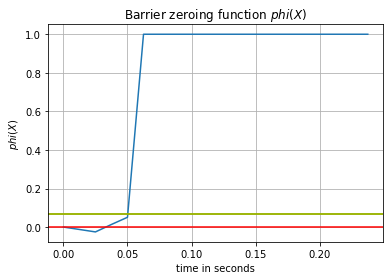

In [21]:
plt.figure()
plt.plot(t[0:N], phi_test[0:N]); plt.axhline(y = 0, c = 'r');plt.axhline(y=theta,c='g'); plt.axhline(y=theta+margin,c='y'); plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('$phi(X)$')
plt.title('Barrier zeroing function $phi(X)$')

Text(0.5, 1.0, 'state space trajectory')

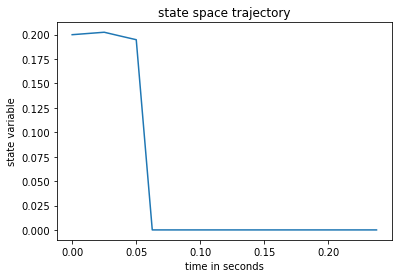

In [22]:
plt.plot(t[0:N],S[0:N])
plt.xlabel('time in seconds')
plt.ylabel('state variable')
plt.title('state space trajectory')

In [23]:
U[:]/S[:]

array([ -1.        ,  -1.        ,  -3.02515712,  -3.02515723,
       -81.49933332, -81.49999447, -81.5       , -81.5       ,
       -81.5       , -81.5       , -81.5       , -81.5       ,
       -81.5       , -81.5       , -81.5       , -81.5       ,
       -81.5       , -81.5       , -81.5       , -81.5       ])

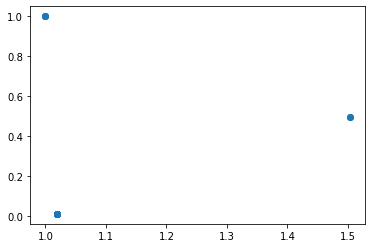

In [24]:
plt.scatter(SEL[0],SEL[1])

In [25]:
#Need to rescale the coarse discretization effects for a proper comparison based simulation

M=1000

P=int(M/N) #Time period through which the last sample remains same


U_cbc=np.zeros(M)
S_cbc=np.zeros(M)
Dot_X_cbc=np.zeros(M)

t_cbc=np.arange(M)*(1/(4*M))

50


In [26]:
count=0

def play_dynamics_cbc(X):
    global count
    #global last_u
    #u=u_nominal(X)
    #u=CBC_controller(X)
    index=int((count-(count%P))/P) #corresponding index
    #print(index)
    u=U[index]
    if (count < M):
        U_cbc[count]=u
        S_cbc[count]=X
        Dot_X_cbc[count]=f(X)+theta_star*F(X)+np.dot(g(X),u)
        count=count+1
    return (f(X)+theta_star*F(X)+np.dot(g(X),u))


In [27]:
def dynamics_runner_cbc(x_0,t):
    d=t.shape[0]
    X_0=np.copy(x_0)
    X=x_0
    X=np.expand_dims(X_0,axis=0)
    #print(np.shape(X))
    dt=t[1]-t[0]
    for i in range(d):
        dX=dt*play_dynamics_cbc(X[i])
        #print(dX)
        X_n=X[i]+dX
        X=np.append(X,[X_n],axis=0)
    return X

In [28]:
X=dynamics_runner_cbc(x_0,t_cbc)

In [29]:
phi_cbc=np.zeros(M)
for i in range(M):
    phi_cbc[i]=phi(S_cbc[i])

Text(0.5, 1.0, 'Barrier zeroing function $phi(X)$')

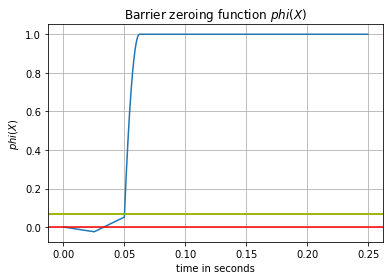

In [30]:
plt.figure()
plt.plot(t_cbc[0:M], phi_cbc[0:M]); plt.axhline(y = 0, c = 'r');plt.axhline(y=theta,c='g'); plt.axhline(y=theta+margin,c='y'); plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('$phi(X)$')
plt.title('Barrier zeroing function $phi(X)$')


#Plot looks good now!!